# $k$ Nearest Neighbor Classification

We apply a simple $k$NN model to the Iris dataset.

In [1]:
import numpy as np

from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [2]:
iris = load_iris()

We split the data in a set of features (`X`) and a set of labels (`y`), each of which was 150 examples, 50 for each class:

In [3]:
X = iris.data
y = iris.target
X.shape, y.shape

((150, 4), (150,))

We use the `MinMaxScaler` to scale the data:


In [4]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

We plot two of the four features and express class affiliation through different colors:

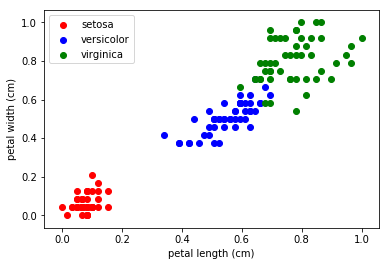

In [5]:
for t in range(3):
    plt.scatter(X[y==t][:,2], X[y==t][:,3], c={0:'red', 1:'blue', 2:'green'}[t], label=iris.target_names[t])
plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])
plt.legend()

We train the model:

In [6]:
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

The model is trained. But how well does it perform? We can calculate the mean accuracy score for the training sample:

In [7]:
model.score(X, y)

1.0

Wow, an accuracy of 100%! This sounds good - and it should make us suspicious...

Why? We did two things wrong:
1. We trained a nearest neighbor model that is only considering the nearest training sample example,
2. and we used the training sample (the same one we used to train the model) to evaluate the trained model's accuracy.

As a result, the model simply maps every training sample example to itself, naturally resulting in an accuracy of 100%. Here's what we can do:
1. increase $k$ to prevent overfitting, and
2. split `X` into a training and test sample.

We will start with splitting the data sample into a training and test sample.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

We check the shapes:

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((100, 4), (100,), (50, 4), (50,))

We check the stratification:

In [10]:
for c in range(3):
    print('class {}: train fraction {}, test fraction {}'.format(c, 
        len(X_train[y_train == c])/len(X_train), 
        len(X_test[y_test == c])/len(y_test)))

class 0: train fraction 0.34, test fraction 0.32
class 1: train fraction 0.33, test fraction 0.34
class 2: train fraction 0.33, test fraction 0.34


Now we train the model only on the training sample and check the score for the training and test samples:

In [11]:
model.fit(X_train, y_train)
print('training sample mean accuracy:', model.score(X_train, y_train))
print('test sample mean accuracy:', model.score(X_test, y_test))

training sample mean accuracy: 1.0
test sample mean accuracy: 0.94


Yes, we are overfitting. Now we have to tune `k` to (1) balance the training and test sample accuracies and to derive the (2) peak test sample accuracy.  

In [12]:
training_scores = []
test_scores = []

for k in range(1, 31):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    training_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

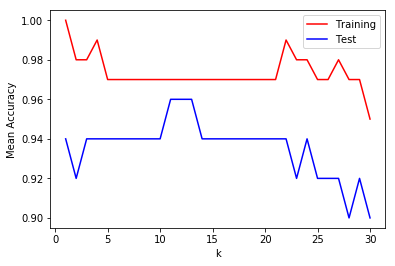

In [13]:
plt.plot(range(1, 31), training_scores, color='red', label='Training')
plt.plot(range(1, 31), test_scores, color='blue', label='Test')
plt.xlabel('k')
plt.ylabel('Mean Accuracy')
plt.legend()

The test sample accuracy is always lower than the training sample accuracy. This might be a result of the splitting and data selection process: we use the same training and test samples all the time. In the best case, those should be randomized, too, using cross-validation (see below).

Anyway, we maximize the test sample accuracy for $k \in \{11, 12,13\}$. Those should be good choices for $k$.

## This is how it should really be done

Combining everything we learned above, we now use a gridsearch cross-validation approach in a "pipeline":

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

X, y = iris.data, iris.target

# split off a validation data set
X_grid, X_val, y_grid, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# define all steps in the pipeline "('name', method), ..."
pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('model', KNeighborsClassifier())])

# define parameter ranges; note the naming scheme 'pipelinename__parametername'
parameters = {'model__n_neighbors': range(1, 31)}

# now we combine everything using GridsearchCV using a 10-fold cross-validation
grid = GridSearchCV(pipeline, parameters, cv=10, return_train_score=True)
grid.fit(X_grid, y_grid)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('model', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model__n_neighbors': range(1, 31)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

The pipeline will run each step that is defined in `pipeline` and automatically call `fit`, `transform`, `predict`, `score`, etc. methods of all pipeline elements as required. This is the reason for the naming scheme used throughout sklearn.

Let's look at the results of `GridSearchCV`:

In [15]:
[a for a in dir(grid) if not a.startswith('__')]

['_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_check_is_fitted',
 '_estimator_type',
 '_get_param_iterator',
 '_get_param_names',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'fit_params',
 'get_params',
 'grid_scores_',
 'iid',
 'inverse_transform',
 'multimetric_',
 'n_jobs',
 'n_splits_',
 'param_grid',
 'pre_dispatch',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'refit',
 'return_train_score',
 'score',
 'scorer_',
 'scoring',
 'set_params',
 'transform',
 'verbose']

There's a lot of stuff. The most important pieces of information are:

In [16]:
# the mean cross-validated score of the best_estimator
grid.best_score_

0.9703703703703703

In [17]:
# the parameters of the best_estimator
grid.best_params_

{'model__n_neighbors': 6}

Now we can compare `best_score_` to the validation set score:

In [18]:
grid.best_estimator_.score(X_val, y_val)

0.9333333333333333

Another useful attribute of `grid` is `cv_results_`.

In [19]:
list(grid.cv_results_.keys())

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_model__n_neighbors',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'split5_test_score',
 'split6_test_score',
 'split7_test_score',
 'split8_test_score',
 'split9_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score',
 'split0_train_score',
 'split1_train_score',
 'split2_train_score',
 'split3_train_score',
 'split4_train_score',
 'split5_train_score',
 'split6_train_score',
 'split7_train_score',
 'split8_train_score',
 'split9_train_score',
 'mean_train_score',
 'std_train_score']

`cv_results_` allows us to look at the results of the individual training and test scores using the different paramter settings and sample splits. We can plot the individual results and mean results: 

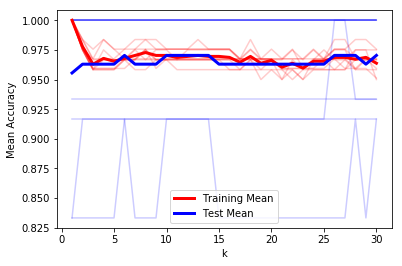

In [20]:
for i in range(10):
    plt.plot(range(1, 31), grid.cv_results_['split{}_train_score'.format(i)], color='red', alpha=0.2)
    plt.plot(range(1, 31), grid.cv_results_['split{}_test_score'.format(i)], color='blue', alpha=0.2)
plt.plot(range(1, 31), grid.cv_results_['mean_train_score'], color='red', label='Training Mean', lw=3)
plt.plot(range(1, 31), grid.cv_results_['mean_test_score'], label='Test Mean', color='blue', lw=3)
plt.xlabel('k')
plt.ylabel('Mean Accuracy')
plt.legend()    

# Random Forest Classification

Given sklearn's modularity, we can simply replace the $k$NN model with a random forest model.

In [21]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('model', RandomForestClassifier(n_jobs=-1, random_state=42))])

parameters = {'model__max_depth': [2, 5, 10],
              'model__max_features': [2, 3],
              'model__n_estimators': [50, 100, 500]}

grid = GridSearchCV(pipeline, parameters, cv=3, return_train_score=True)
grid.fit(X_grid, y_grid)

/home/mommermi/software/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, mi...imators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model__max_depth': [2, 5, 10], 'model__max_features': [2, 3], 'model__n_estimators': [50, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [22]:
grid.best_score_, grid.best_params_

(0.9703703703703703,
 {'model__max_depth': 2, 'model__max_features': 3, 'model__n_estimators': 100})

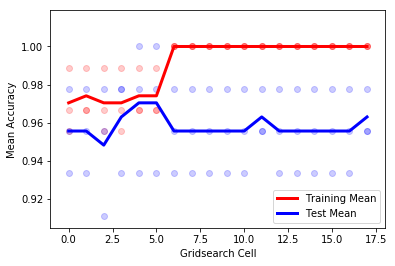

In [23]:
for i in range(3):
    plt.scatter(range(18), grid.cv_results_['split{}_train_score'.format(i)], color='red', alpha=0.2)
    plt.scatter(range(18), grid.cv_results_['split{}_test_score'.format(i)], color='blue', alpha=0.2)
plt.plot(range(18), grid.cv_results_['mean_train_score'], color='red', label='Training Mean', lw=3)
plt.plot(range(18), grid.cv_results_['mean_test_score'], label='Test Mean', color='blue', lw=3)
plt.xlabel('Gridsearch Cell')
plt.ylabel('Mean Accuracy')
plt.legend()  

# Random Forest Regression

Let's take a look at a different dataset. We will predict house prices in Boston.

The important take-away here is that regression works exactly like classfication using sklearn.

In [24]:
from sklearn.datasets import load_boston

boston = load_boston()

In [25]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

We will try to predict the median value:

In [26]:
X, y = boston.data, boston.target

# split off a validation data set
X_grid, X_val, y_grid, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [27]:
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

parameters = {'model__max_depth': [10, 20, 50],
              'model__max_features': [5, 10, 12],
              'model__n_estimators': [50, 100, 500]}

grid = GridSearchCV(pipeline, parameters, cv=3, return_train_score=True)
grid.fit(X_grid, y_grid)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model__max_depth': [10, 20, 50], 'model__max_features': [5, 10, 12], 'model__n_estimators': [50, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [28]:
grid.best_score_, grid.best_params_

(0.8733763238432611,
 {'model__max_depth': 50,
  'model__max_features': 10,
  'model__n_estimators': 100})

The regressor returns in this case the coefficient of determination, $r^2$, as metric. 

In [29]:
grid.best_estimator_.score(X_val, y_val)

0.879851085543939

This is useful, but you might want to know by what fraction your predicted values are off:  

In [30]:
from sklearn.metrics import mean_squared_log_error

mean_squared_log_error(y_val, grid.best_estimator_.predict(X_val))

0.016405354025961816

We're off by less than 2% RMS. That's a good result!

One cool feature of random forests is that they derive a measure called "feature importances":

In [31]:
for i in range(len(boston.feature_names)):
    print(boston.feature_names[i], grid.best_estimator_.steps[1][1].feature_importances_[i])

CRIM 0.03921425797071844
ZN 0.0015571693050164842
INDUS 0.015959744834188567
CHAS 0.0011876703618266594
NOX 0.03301146030842204
RM 0.3785726124358541
AGE 0.013972026495347914
DIS 0.06729134265288068
RAD 0.003164170534750944
TAX 0.01557604311030616
PTRATIO 0.02144295173282043
B 0.013212091181979812
LSTAT 0.3958384590758878


The most important features are `RM` (number of rooms) and `LSTAT` (percentage of lower status of the population). 